# Identifying type of opinions in spanish wikipedia discussions 

In this analysis, we are going to automatically identify the kind of opinion of authors in the discussions on talk pages of spanish wikipedia.

In [170]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18


Load our labelled dataset, containing the opinions in the talk pages of wikipedia segmented by sentences assuming normal punctuation. This dataset includes the initial 1000 edits of talk pages of political leaders in America.

In [171]:
ds = pd.read_csv('data/wdds_v01.csv')
ds['creation_dt'] = pd.to_datetime(ds['timestamp'], unit='s')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 12 columns):
row_id         1204 non-null object
page_id        1203 non-null float64
page_title     1203 non-null object
contributor    1203 non-null object
timestamp      1203 non-null float64
topic          1122 non-null object
opinion        1203 non-null object
type           1204 non-null object
subtype        0 non-null float64
stance         0 non-null float64
sentiment      0 non-null float64
creation_dt    1203 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 113.0+ KB


remove unnecesary label 'discusión' in title

In [172]:
ds['page_title'] = ds.page_title.str.replace('Discusión:', '')

# exploratory analysis
Lets look the distribution of discussions per talk page

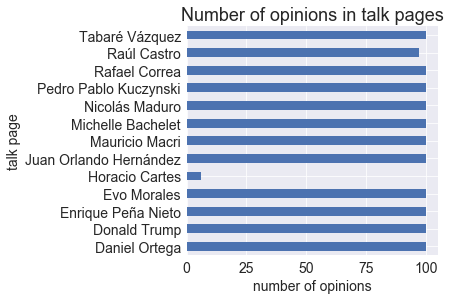

In [173]:
discussion_perpage= ds.groupby('page_title').size()
discussion_perpage.plot.barh()
plt.xlabel('number of opinions')
plt.ylabel('talk page')
plt.title('Number of opinions in talk pages')
plt.tight_layout()
plt.savefig('output/opiniontalkpagesdist.eps', format='eps')

In [174]:
sample=ds[~ds.topic.isnull()][['contributor','topic','opinion', 'type']].head()
sample.to_csv('output/sample.csv', index=False, sep='|')

almost all talk pages have same sample size, except one.  Now, lets look at the number of opinions by editor.

In [175]:
print(f'unique authors: {ds.contributor.nunique()}')

unique authors: 177


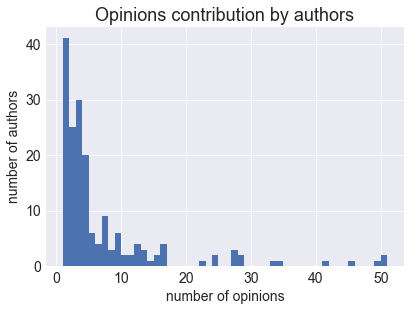

In [176]:
discussion_pereditor= ds.groupby('contributor').size()
discussion_pereditor= discussion_pereditor.sort_values(ascending=False)
discussion_pereditor.hist(bins=50)
plt.xlabel('number of opinions')
plt.ylabel('number of authors')
plt.title('Opinions contribution by authors')
plt.savefig('output/opauthorcontribdist.eps', format='eps')

Most authors have 10 or less opinions.  It could be useful to know if there are authors with opinions in multiple talk pages

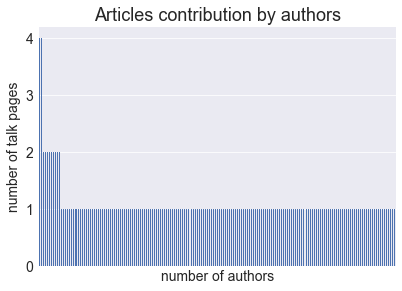

In [177]:
discussion_editor=ds.groupby(['contributor', 'page_title']).size().reset_index()
discussion_editor=discussion_editor['contributor'].value_counts()
discussion_editor=discussion_editor.reset_index() #.plot.area()
discussion_editor.plot.bar()
plt.legend([])
plt.xlabel('number of authors')
plt.xticks([])
plt.ylabel('number of talk pages')
plt.title('Articles contribution by authors')
plt.savefig('output/articlesauthorcontribdist.eps', format='eps')

Most authors only contribute to one discussions, with few authors contributing to two or more discussions.  Another aspect, it is the temporal distribution, lets look at it:

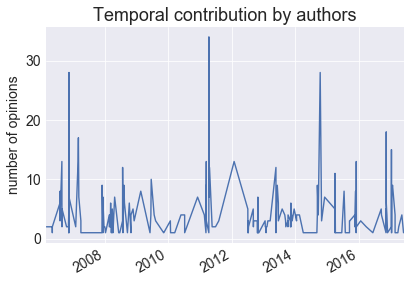

In [178]:
ts = ds.groupby(['creation_dt']).size()
ts.plot()
plt.xlabel('')
plt.ylabel('number of opinions')
plt.title('Temporal contribution by authors')
plt.savefig('output/temporalauthorcontribdist.eps', format='eps')

it seems there's some spikes at certain dates, probably related to real world events.  Now, let make the text analysis of the opinions.

# label analysis

let's look at the column that indicates the opinion type according to the taxonomy defined in the literature.

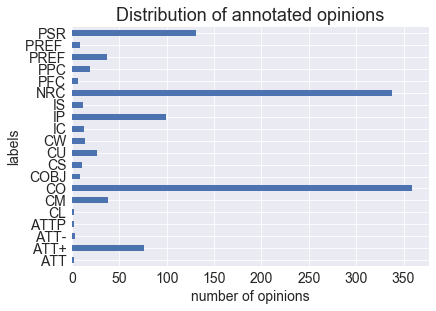

In [179]:
ds[['row_id','type']].groupby('type').count().plot.barh()
plt.xlabel('number of opinions')
plt.ylabel('labels')
plt.legend('')
plt.title('Distribution of annotated opinions')
plt.savefig('output/annotatedopinionsdist.eps', format='eps')

since the labels are unbalanced, in order to avoid problems in the classification task, we will select those types with more than 100 instances

In [180]:
ds=ds[ds.type.isin(['PSR','NRC', 'CO', 'IP', 'ATT+'])]
ds[['row_id','type']].groupby('type').count()

,row_id
type,
ATT+,76
CO,359
IP,99
NRC,338
PSR,131


In [262]:
labels = pd.read_csv('data/labels.csv')
labels_dict = labels['Label'].to_dict()
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
Label          33 non-null object
Category       33 non-null object
Name           33 non-null object
Description    23 non-null object
dtypes: object(4)
memory usage: 1.1+ KB


In [278]:
ds_r1 = pd.read_csv('data/wdds_v01_r1.csv')
ds_r2 = pd.read_csv('data/wdds_v01.csv')
ds_r1=ds_r1[ds_r1.type.isin(['PSR','NRC', 'CO', 'IP', 'ATT+'])]
ds_r2=ds_r2[ds_r2.type.isin(['PSR','NRC', 'CO', 'IP', 'ATT+'])]

#ds_r2['type'] = ds_r2.type.apply(lambda x: labels_dict[np.random.randint(0,len(labels))])
print(f'ds reviewer 1:{ds_r1.shape}')
print(f'ds reviewer 2:{ds_r2.shape}')
ds_r = pd.merge(ds_r1, ds_r2, on=['row_id', 'page_id'])
print(f'ds reviewer:{ds_r.shape}')
ds_r['agreement'] = ds_r.type_x == ds_r.type_y
ds_r['agreement'] = ds_r['agreement'].apply(lambda x: float(x))
ds_rs = ds_r.groupby('type_x').agg({'agreement': 'mean'})
ds_rs = ds_rs.reset_index()
ds_rs.columns=['type', 'agreement']
ds_rs['kappa'] = 0
ds_r['type'] = ds['type']

from sklearn.metrics import cohen_kappa_score

groups = ds_r.groupby('type')

for name, group in groups:
    score= cohen_kappa_score(group.type_x, group.type_y)
    print(name,score)
    ds_rs.loc[ds_rs['type']==name,'kappa']=score
    
ds_rs.to_csv('output/agreement.csv', index=False)
ds_rs

ds reviewer 1:(1003, 11)
ds reviewer 2:(1003, 11)
ds reviewer:(1003, 20)
ATT+ 1.0
CO 1.0
IP 1.0
NRC 1.0
PSR 1.0


,type,agreement,kappa
0,ATT+,1.0,1.0
1,CO,1.0,1.0
2,IP,1.0,1.0
3,NRC,1.0,1.0
4,PSR,1.0,1.0


# text analysis

First, lets look characterize the opinions. First, let's analyze the length of the opinions and number of words

In [181]:
ds['oplen'] = ds.opinion.str.len()

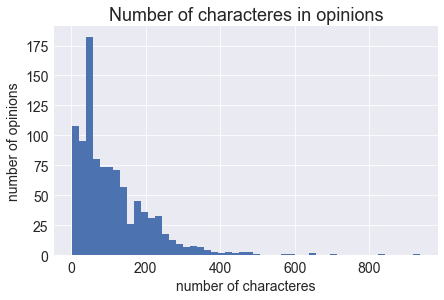

In [182]:
ds.oplen.hist(bins=50)
plt.xlabel('number of characteres')
plt.ylabel('number of opinions')
plt.title('Number of characteres in opinions')
plt.tight_layout()
plt.savefig('output/numcharsopdist.eps', format='eps')

as in most human activities, the length of opinions follow an power law distribution.  Now, let's look at the number of words:

In [183]:
from nltk.tokenize import word_tokenize

In [184]:
ds.opinion.fillna(value='', inplace=True)

In [185]:
ds['opnumwords'] = ds.opinion.apply(lambda s: len(word_tokenize(s, 'spanish')))

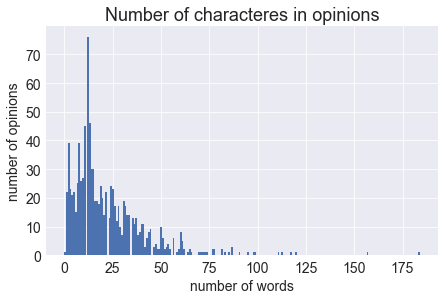

In [186]:
ds.opnumwords.hist(bins=200)
plt.xlabel('number of words')
plt.ylabel('number of opinions')
plt.title('Number of characteres in opinions')
plt.tight_layout()
plt.savefig('output/numwordsopdist.eps', format='eps')

as expected the distribution of length of words is very similar to characters in opinions. Although there are opinions with only one word, it may be useful to know what kind of opinions are those:

In [187]:
ds[ds.opnumwords<2].opinion.value_counts()

0               4
Err:508         2
etc..           2
criminalidad    1
|               1
...             1
4               1
2               1
saludos         1
______          1
1               1
|-              1
gracias         1
3               1
!               1
messhermit      1
paz             1
                1
Name: opinion, dtype: int64

some of them are meaningless others make sense such as: saludos, paz, gracias.  One of the challeges in the classification task will be to filter out meaningless words but filtering out useful words, specially when both have the similar frequencies.  Let's look at most used words with a word cloud for raw text.

number of words: 114970


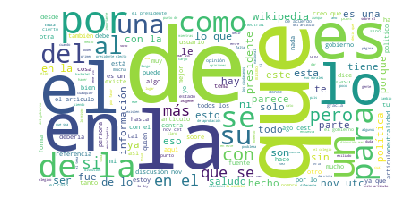

In [188]:
from wordcloud import WordCloud
words = ' '.join(ds.opinion)
wordcloud = WordCloud(background_color="white", max_words=200).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
print(f'number of words: {len(words)}')

most common words are stop words, let's remove them 

number of words: 13461
number of words: 10000
number of words: 416


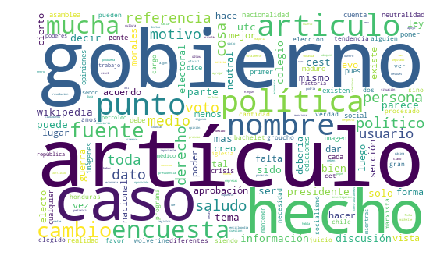

In [245]:
from nltk.corpus import stopwords
import re

stopset = set(stopwords.words('english') + stopwords.words('spanish'))

def tokenize(text):
    text = re.sub(r"(?:\#|@|https?\://)\S+", "", text)
    text = re.sub("[^a-zA-Z] ","",text)
    text = re.sub(r'\b\w{1,2}\b',' ',text)
    text = re.sub(r'http[\bs]*',' ',text)
    tokens = word_tokenize(text)
    return tokens

word_list = word_tokenize(words)
word_list = [word for word in word_list if word not in stopset]
print(f'number of words: {len(word_list)}')
word_list = tokenize(words)
word_list = [word for word in word_list if word not in stopset]
print(f'number of words: {len(word_list)}')

wds = pd.DataFrame(word_list)
wds.columns = ['word']
wds=wds.word.value_counts().reset_index()
wds.columns=['word', 'count']
#wds[wds.word.str.contains('hola')]
wds=wds[wds['count']>3]
print(f'number of words: {len(wds)}')

filtered_words = ' '.join(wds.word)
wordcloud = WordCloud(background_color='white', width=500, height=300).generate(filtered_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()
plt.savefig('output/wordcloud.eps', format='eps')


much better! probably it will improve with steeming and lemmatization for the classification task

# classification task

For the classification task, let's analyze the labels distribution.

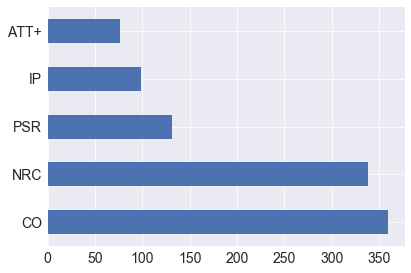

In [261]:

#ds['target'] = ds.apply(lambda row: labels_dict[row['type']], 1)
ds['target'] = ds['type']
ds['target'].value_counts().plot.barh()

as we can see, the labels are fairly balanced, so we can apply the classification task based on type columns

## Splitting the data

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    ds.opinion, ds.target, test_size=0.4, random_state=0)
                                                    

In [193]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(strip_accents='ascii', min_df=4,
                             stop_words=stopset, tokenizer=tokenize)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(601, 235)

In [194]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(601, 235)

In [195]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, y_train)

In [196]:
sample = X_test[:2]
sample_labels = y_test[:2]
list(zip(sample, sample_labels))

[('estos detalles insensatos no ayudan al lectgor en lo más mínimo en comprender hernández, ni como persona ni como presidente de honduras.',
  'CO'),
 ('aspectos asociados al 27f y su trabajo en onu mujeres, con mayor o menor desarrollo.',
  'NRC')]

In [197]:
docs_new = sample
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, category))


'estos detalles insensatos no ayudan al lectgor en lo más mínimo en comprender hernández, ni como persona ni como presidente de honduras.' => CO
'aspectos asociados al 27f y su trabajo en onu mujeres, con mayor o menor desarrollo.' => NRC


## Building a pipeline

In [198]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(strip_accents='ascii', stop_words=stopwords.words('spanish'))),
                     ('tfidf', TfidfTransformer(use_idf=True)),
                     ('clf', MultinomialNB()),
])

In [199]:
text_clf = text_clf.fit(X_train, y_train)

## Evaluation of the performance on the test set

In [279]:
docs_test = X_test
predicted = text_clf.predict(docs_test)
np.mean(predicted == y_test)            


0.55472636815920395

In [243]:
from sklearn.metrics import precision_recall_fscore_support
results = precision_recall_fscore_support(y_test, predicted)

labels = y_test.unique()
labels.sort()

d={'label':pd.Series(labels),
  'precision':pd.Series(results[0]),
  'recall':pd.Series(results[1]),
  'f1-score':pd.Series(results[2]),
  'support':pd.Series(results[3])}
rds = pd.DataFrame(d)
rds = rds[['label', 'precision', 'recall','f1-score','support']]

rdstotal=rds.agg({
    'precision':'mean', 
    'recall':'mean',
    'f1-score':'mean',
    'support':'sum'})
rdstotal=rds.append(rdstotal, ignore_index=True)
rdstotal.iloc[-1,rdstotal.columns.get_loc('label')] = 'avg / total' 
rdstotal.to_csv('output/classif_report.csv', index=False)
rdstotal

,label,precision,recall,f1-score,support
0,ATT+,1.000000,0.307692,0.470588,26.0
1,CO,0.494585,0.895425,0.637209,153.0
2,IP,1.000000,0.076923,0.142857,26.0
3,NRC,0.657895,0.506757,0.572519,148.0
4,PSR,1.000000,0.020408,0.040000,49.0
5,avg / total,0.830496,0.361441,0.372635,402.0


In [202]:
metrics.confusion_matrix(y_test, predicted)

array([[  8,   3,   0,  15,   0],
       [  0, 137,   0,  16,   0],
       [  0,  22,   2,   2,   0],
       [  0,  73,   0,  75,   0],
       [  0,  42,   0,   6,   1]])